In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def generate_complex_clusters(n_clusters, complexity=1.5, size=64):
    """
    Generate complex clusters with guaranteed valid output
    """
    # Initialize centers with proper spacing
    centers = []
    base_spreads = np.random.lognormal(mean=-0.3, sigma=0.5, size=n_clusters) + 1.2
    spreads = base_spreads * (1 + complexity * 0.3)
    
    # Generate valid centers
    for _ in range(n_clusters):
        for attempt in range(200):
            new_center = np.random.uniform(size*0.1, size*0.9, 2)
            if all(np.linalg.norm(new_center - c) > (s1 + s2) * 1.8
               for c, s1, s2 in zip(centers, base_spreads[:len(centers)], 
                                   spreads[:len(centers)])):
                centers.append(new_center)
                break

    all_clusters = []
    shape_types = ['spiral', 'multi_center', 'fractal', 'concentric']
    probs = [0.4, 0.3, 0.2, 0.1]  # Reduced probability for concentric
    
    for i in range(len(centers)):
        n_points = int(np.clip(np.random.lognormal(mean=5.3, sigma=0.3), 150, 600))
        shape = np.random.choice(shape_types, p=probs)
        current_spread = spreads[i] * (1 + np.random.uniform(-0.15, 0.15))
        
        if shape == 'spiral':
            theta = np.linspace(0, 5*np.pi, n_points)
            r = np.linspace(0, current_spread*2.5, n_points)
            x = centers[i][0] + r * np.cos(theta + complexity*np.sin(theta/2))
            y = centers[i][1] + r * np.sin(theta + complexity*np.cos(theta/3))
            
        elif shape == 'multi_center':
            sub_centers = centers[i] + np.random.uniform(-current_spread*1.2, 
                                                        current_spread*1.2, 
                                                        (3, 2))
            points = []
            for j, sc in enumerate(sub_centers):
                cov = current_spread * np.array([
                    [1 + 0.1*j, 0.05*complexity],
                    [0.05*complexity, 1 + 0.1*j]
                ])
                cov = (cov + cov.T) / 2 + np.eye(2) * 0.1
                sz = max(10, int(n_points * (0.3 + 0.05*j)))  # Ensure minimum points
                points.append(multivariate_normal.rvs(mean=sc, cov=cov, size=sz))
            points = np.vstack(points)
            x, y = points[:,0], points[:,1]
            
        elif shape == 'fractal':
            theta = np.random.uniform(0, 2*np.pi, n_points)
            r = current_spread * np.random.weibull(1.3, n_points)
            x = centers[i][0] + r * np.cos(theta + complexity*np.sin(4*theta))
            y = centers[i][1] + r * np.sin(theta + complexity*np.cos(3*theta))
            
        else:  # concentric - modified to ensure at least one ring
            n_rings = max(1, int(complexity))
            rings = []
            for ring in range(1, n_rings + 1):
                n_ring_points = max(10, n_points // n_rings)
                theta = np.random.uniform(0, 2*np.pi, n_ring_points)
                r = current_spread * ring/n_rings * (1 + np.random.normal(0, 0.1, n_ring_points))
                rings.append(np.column_stack((
                    centers[i][0] + r * np.cos(theta),
                    centers[i][1] + r * np.sin(theta)
                )))
            x, y = np.vstack(rings).T
        
        # Apply noise and clipping
        noise = np.random.normal(0, current_spread*0.2*complexity, (len(x), 2))
        points = np.column_stack((x, y)) + noise
        points = np.clip(points, 0, size)
        
        all_clusters.append(points)
    
    return all_clusters , centers

def plot_data(data, ax=None):
    if ax is None:
        ax = plt.gca() 
    ax.scatter(data[:, 0], data[:, 1], s=8, alpha=0.6)
    ax.axis('equal')

def plot_clusters(clusters, ax=None):
    if ax is None:
        ax = plt.gca()
    colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))
    for i, cluster in enumerate(clusters):
        ax.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], s=8, alpha=0.6)
    ax.axis('equal')


def model_accuracy(guessed_clusters , clusters):
# Accuracy in the number of clusters =  difference / number of cluster

    points = np.vstack(clusters)

# Calculating accuracy in the number of clusters
    # Calculating the distance from the center
    SumOfDistance_center = 0
    for cluster in clusters: 
        cluster = np.array(cluster)
        center = [np.mean(cluster[:,0]) , np.mean(cluster[:,1])]
        for points in cluster:
            distance = ((points[0] - center[0])**2 + (points[1] - center[1])**2)
            SumOfDistance_center += distance

    # Calculating the distance from the guessed center
    SumOfDistance_GuessedCenter = 0
    for cluster in guessed_clusters:
        cluster = np.array(cluster)
        center = [np.mean(cluster[:,0]) , np.mean(cluster[:,1])]
        for points in cluster:
            distance = ((points[0] - center[0])**2 + (points[1] - center[1])**2)
            SumOfDistance_GuessedCenter += distance

    AccuracyInThe_LocationOfCenter = abs(SumOfDistance_center - SumOfDistance_GuessedCenter)*np.log10(len(clusters)) / SumOfDistance_center 

    return (1 -  AccuracyInThe_LocationOfCenter)*100


In [3]:
def kmeans_clustering(points, max_clusters=20 , plot=False):
    best_score = -1
    optimal_k = 2
    best_centers = None
    best_labels = None
    
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(points)
        score = silhouette_score(points, labels)
        
        if score > best_score:
            best_score = score
            optimal_k = k
            best_centers = kmeans.cluster_centers_
            best_labels = labels
    
    clstr = [[]  for _ in range(optimal_k)]
    for i in range(len(points)):
        clstr[best_labels[i]].append(points[i])

    clusters = []
    for cluster in clstr:
        clusters.append(np.array(cluster))

    if plot:
        plt.figure(figsize=(10, 8))
        plt.scatter(points[:, 0], points[:, 1] , c=best_labels)
        # plt.title(f'Optimal Clusters: {optimal_k}', pad=20)
        # plt.legend()
        # plt.axis('equal')
        plt.show()
    
    return clusters

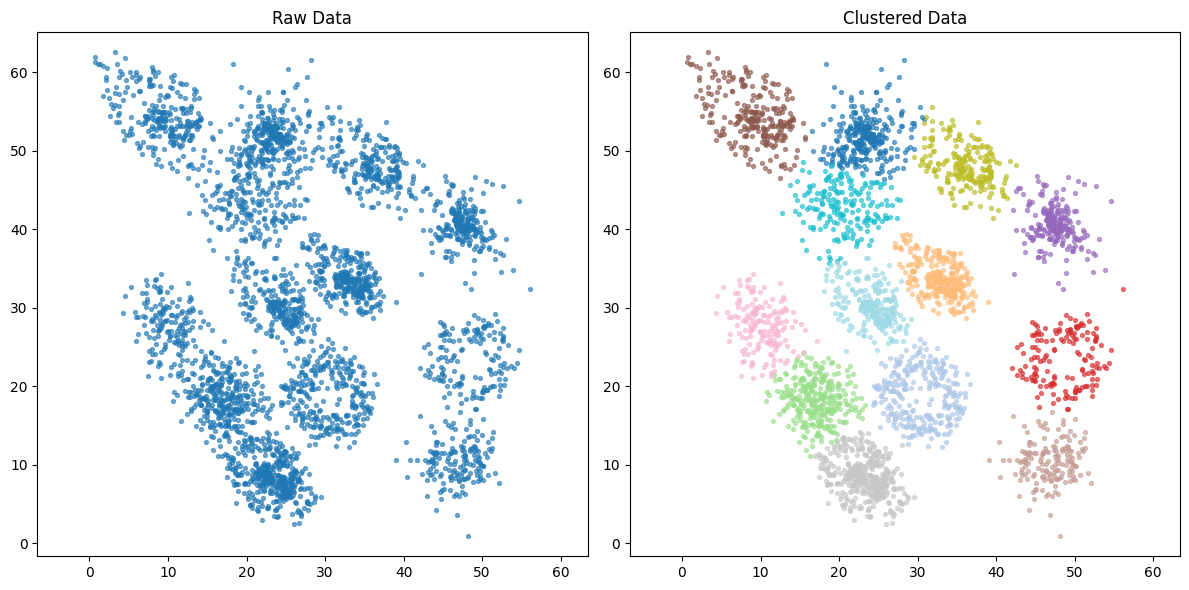

In [4]:
data  , centers= generate_complex_clusters(13)
data = np.vstack(data)
clusters = kmeans_clustering(data)
plt.figure(figsize=(12, 6)) 


ax1 = plt.subplot(1, 2, 1)
plot_data(data, ax=ax1)  
plt.title("Raw Data")

ax2 = plt.subplot(1, 2, 2)
plot_clusters(clusters, ax=ax2)  
plt.title("Clustered Data")

plt.tight_layout()
plt.show()
